# Digital Earth Australia Coastlines <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** [DEA Coastlines](https://cmi.ga.gov.au/data-products/dea/581/dea-coastlines-landsat)

## Background

**Digital Earth Australia Coastlines** (DEA Coastlines) is a continental dataset that includes annual shorelines and rates of coastal change along the entire Australian coastline from 1988 to the present. 

The product combines satellite data from Geoscience Australia's [Digital Earth Australia program](https://www.ga.gov.au/dea) with tidal modelling to map the typical location of the coastline at mean sea level for each year. The product enables trends of coastal erosion and growth to be examined annually at both a local and continental scale, and for patterns of coastal change to be mapped historically and updated regularly as data continues to be acquired. This allows current rates of coastal change to be compared with that observed in previous years or decades. 

The ability to map shoreline positions for each year provides valuable insights into whether changes to our coastline are the result of particular events or actions, or a process of more gradual change over time. This information can enable scientists, managers and policy makers to assess impacts from the range of drivers impacting our coastlines and potentially assist planning and forecasting for future scenarios. 

### Applications
* Monitoring and mapping rates of coastal erosion along the Australian coastline 
* Prioritise and evaluate the impacts of local and regional coastal management based on historical coastline change 
* Modelling how coastlines respond to drivers of change, including extreme weather events, sea level rise or human development 
* Supporting geomorphological studies of how and why coastlines have changed across time 

## Description

This Jupyter Notebook tools includes useful tools for analysing DEA Coastlines data, including:

1. Loading DEA Coastlines data in a Jupyter notebook or Python using the DEA Coastlines Web Feature Service (WFS)
2. Interactively drawing a transect across DEA Coastlines annual coastlines and generating a plot of coastal change through time
3. Interactively plotting the distribution of retreating and growing coastlines within a selected region

> **Note:** For the most up-to-date information about this product, visit the official [Geoscience Australia DEA Coastlines product description](https://cmi.ga.gov.au/data-products/dea/581/dea-coastlines-landsat)

---

## Load modules/functions


In [1]:
import re
import os
import uuid
import subprocess
import pandas as pd
import xarray as xr
import geopandas as gpd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shapely.geometry import box, shape

# Widgets and WMS
from odc.ui import ui_poll, select_on_a_map
from ipyleaflet import (Map, WMSLayer, WidgetControl, FullScreenControl, 
                        DrawControl, basemaps, basemap_to_tiles, TileLayer)
from ipywidgets.widgets import Layout, Button, HTML
from owslib.wms import WebMapService
from IPython.display import display
from types import SimpleNamespace

        
def wms_layers_styles(url):
    """
    Returns a dataframe of available layer styles for a given Web Map 
    Service (WMS) URL.
    
    Parameters
    ----------
    url : string
        A URL giving the path to the Web Map Service (WMS), e.g.
        `url='https://ows.dea.ga.gov.au/'
    """
    
    # Get WMS data from URL
    wms_items = dict(WebMapService(url, version='1.3.0').items())
    
    return wms_items
    layers_styles = {key: val.styles.keys() for key, val in wms_items.items()}

    # Create a dataframe with an index of layer names and list of styles
    layers_df = pd.DataFrame(index=layers_styles.keys())
    layers_df['styles'] = layers_styles.values()
    layers_df.index.name = 'layer'
    
    # Print output
    with pd.option_context('display.max_rows', None, 
                           'display.max_colwidth', 255):
        display(layers_df)
    
    return layers_df


def wms_xarray(url,
               layer,
               layerstyle,
               layertime,
               bbox,
               layerformat='png',
               layersizex=512,
               layersizey=512,
               output_crs='EPSG:4326'):
    """
    Loads Web Map Service (WMS) data into memory as a `xarray.Dataset`
    object.
    
    Parameters
    ----------
    url : string
        A URL giving the path to the Web Map Service (WMS) to load as an
        xarray. e.g. `url='https://ows.dea.ga.gov.au/'`
    layer: string
        A string giving the name of the specific WMS layer to load,
        e.g. `layer='ls8_nbart_geomedian_annual'`
    layerstyle : string
        The specific WMS layer style to load, e.g. 
        `layerstyle='simple_rgb'`
    layertime : string
        The specific timestep to load from the WMS, in the format:
        `layertime='2018-01-01T00:00:00.000Z'`
    bbox : tuple or list
        The bounding box to load data for in the form:
        `[y_max, x_min, y_min, x_max]`
    layerformat : string, optional
        The image format to load data in. Defaults to 'png'.
    layersizex, layersizey : int, optional
        The dimensions at which the data should be loaded. The default
        is 512 x 512 pixels; note that this will resample the original
        data sometimes considerably, so generally should be used for
        visualisation rather than quantitative scientific applications.
    output_crs : string, optional
        The CRS to reproject the loaded data to. Defaults to WGS 84 or
        'EPSG:4326'.
    """

    # Get extent from bounding box
    y_max, x_min, y_min, x_max = bbox

    # Create tempory path files
    unique_id = str(uuid.uuid4())
    infile = f'{unique_id}.tif'
    outfile = f'{unique_id}_georef.tif'

    wms = WebMapService(url, version='1.3.0')
    crs = sorted(wms[layer].crsOptions)
    time = wms[layer].timepositions
    
    # Load data from WMS
    output = wms.getmap(layers=[layer],
                        styles=[layerstyle],
                        srs='EPSG:4326',
                        bbox=(x_min, y_min, x_max, y_max),
                        size=(layersizex, layersizey),
                        format=f'image/{layerformat}',
                        time=layertime)
            
    # Write to an external raster and reproject using gdal_translate
    with open(infile, 'wb') as out:
        out.write(output.read())   
    subprocess.call(['gdal_translate','-a_srs', output_crs, 
                     '-a_ullr', str(x_min), str(y_max), str(x_max), str(y_min), 
                     infile, outfile])
    ds = xr.open_rasterio(outfile)
    
    # Remove temporary rasters
    os.remove(outfile)
    os.remove(infile)
    
    return(ds)


def polyline_select(center=(-26, 135),
                    zoom=4,
                    height='600px'):
    """
    Allows the user to interactively draw a polyline on the map with a 
    DEA CoastLines overlay.
    """    
  
    def update_info(txt):
        html_info.value = '<pre style="color:grey">' + txt + '</pre>'

    def render_bounds(bounds):
        (lat1, lon1), (lat2, lon2) = bounds
        txt = 'lat: [{:.{n}f}, {:.{n}f}]\nlon: [{:.{n}f}, {:.{n}f}]'.format(
            lat1, lat2, lon1, lon2, n=4)
        update_info(txt)
        
    def on_done(btn):
        state.done = True
        btn_done.disabled = True
        m.remove_control(draw)
        for w in widgets:
            m.remove_control(w)

    def bounds_handler(event):
        bounds = event['new']
        render_bounds(bounds)
        (lat1, lon1), (lat2, lon2) = bounds
        state.bounds = dict(lat=(lat1, lat2),
                            lon=(lon1, lon2))

    def on_draw(event):
        v = event['new']
        action = event['name']
        if action == 'last_draw':
            state.selection = v['geometry']
        elif action == 'last_action' and v == 'deleted':
            state.selection = None

        btn_done.disabled = state.selection is None
        

    state = SimpleNamespace(selection=None,
                            bounds=None,
                            done=False)
    
    # Set up "Done" button
    btn_done = Button(description='done',
                      layout=Layout(width='5em'))
    btn_done.style.button_color = 'green'
    btn_done.disabled = True

    html_info = HTML(layout=Layout(flex='1 0 20em',
                                   width='20em',
                                   height='3em'))

    # Load DEACoastLines WMS
    deacl_url='https://geoserver.dea.ga.gov.au/geoserver/wms'
    deacl_layer='dea:DEACoastLines'
    wms = WMSLayer(url=deacl_url,
                   layers=deacl_layer,
                   format='image/png',
                   transparent=True,
                   attribution='DEA CoastLines © 2020 Geoscience Australia')
    
    # Plot interactive map to select area
    basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
    places = TileLayer(url=('https://server.arcgisonline.com/ArcGIS/rest/'
                            'services/Reference/World_Boundaries_and_Places'
                            '/MapServer/tile/{z}/{y}/{x}'), opacity=1)
    m = Map(layers=(basemap, wms, places, ),
            height=height,
            center=center, 
            zoom=zoom)
    m.scroll_wheel_zoom = True

    # Set up done and info widgets
    widgets = [WidgetControl(widget=btn_done, position='topright'),
               WidgetControl(widget=html_info, position='bottomleft')]
    for w in widgets:
        m.add_control(w) 
        
    # Add polyline draw control option
    draw = DrawControl(circlemarker={}, polygon={})
    m.add_control(draw)
    m.add_control(FullScreenControl())
    draw.polyline =  {'shapeOptions': {'color': 'red', 'opacity': 1.0}}

    # Set up interactivity
    draw.observe(on_draw)
    m.observe(bounds_handler, ('bounds',))
    btn_done.on_click(on_done)

    return m, state


def deacl_transect(transect_mode='distance',
                   export_csv=True,
                   export_transect=True,
                   export_figure=True,
                   length_limit=50):
    
    """
    Function for interactively drawing a transect line on a map,
    and using this line to extract distances to each annual DEA 
    Coastlines coastline along the transect. The function can also be
    used to measure the width between two coastlines from the same year
    through time.
    
    Parameters
    ----------
    transect_mode : string, optional
        An optional string indicating whether to analyse coastlines 
        using 'distance' or 'width' mode. The "distance" mode measures the 
        distance from the start of the transect to each of the annual
        coastlines, and will ignore any coastline that intersects the 
        transect more than once. The 'width' mode will measure the 
        width between two coastlines from the same year, which can be
        useful for measuring e.g. the width of a tombolo or sandbank 
        through time. This mode will ignore any annual coastline that 
        intersections with the transect only once.
    export_csv : boolean, optional
        An optional boolean indicating whether to export the transect
        data as a CSV file. This file will be automatically named using 
        its centroid coordinates, and exported into the directory this 
        code is being run in. The default is True.
    export_transect : boolean, optional
        An optional boolean indicating whether to export the transect
        data as a GeoJSON and ESRI Shapefile. This file will be 
        named automatically using its centroid coordinates, and exported
        into the directory this code is being run in. Default is True.
    export_figure : boolean, optional
        An optional boolean indicating whether to export the transect
        figure as an image file. This file will be automatically named 
        using its centroid coordinates, and exported into the directory 
        this code is being run in. The default is True.
    """
    
    # Run interactive map
    m, state = polyline_select()
    display(m)
    
    def extract_geometry(state):        
        
        # Convert geometry to a GeoSeries
        profile = gpd.GeoSeries(shape(state.selection), 
                                crs='EPSG:4326')  
        
        # Test length
        transect_length = (profile.to_crs('EPSG:3577').length / 1000).sum()
        if transect_length > length_limit:
            raise ValueError(f'Your transect is {transect_length:.0f} km long. '
                             f'Please draw a transect that is less than '
                             f'{length_limit} km long.\nTo draw a shorter '
                             f'transect, re-run the cell above and draw a new '
                             f'polyline.')

        # Load data from WFS
        print('Loading DEA Coastlines data...\n')
        xmin, ymin, xmax, ymax = profile.total_bounds
        deacl_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                    f'service=WFS&version=1.1.0&request=GetFeature' \
                    f'&typeName=dea:coastlines&maxFeatures=1000' \
                    f'&bbox={ymin},{xmin},{ymax},{xmax},' \
                    f'urn:ogc:def:crs:EPSG:4326'
        deacl = gpd.read_file(deacl_wfs)
        deacl.crs = 'EPSG:3577'

        # Raise exception if no coastlines are returned
        if len(deacl.index) == 0:
            raise ValueError('No annual coastlines were returned for the '
                             'supplied transect. Please select another area.')
            
        # Dissolve by year to remove duplicates, then sort by date
        deacl = deacl.dissolve(by='year', as_index=False)
        deacl['year'] = deacl.year.astype(int)
        deacl = deacl.sort_values('year')

        # Extract intersections and determine type
        profile = profile.to_crs('EPSG:3577')
        intersects = deacl.apply(
            lambda x: profile.intersection(x.geometry), axis=1)
        intersects = gpd.GeoSeries(intersects[0])   
        
        # Select geometry depending on mode
        intersects_type = (intersects.type == 'Point' if 
                           transect_mode == 'distance' else 
                           intersects.type == 'MultiPoint')

        # Remove annual data according to intersections
        deacl_filtered = deacl.loc[intersects_type]
        drop_years = ', '.join(deacl.year
                               .loc[~intersects_type]
                               .astype(str)
                               .values.tolist())

        # In 'distance' mode, analyse years with one intersection only
        if transect_mode == 'distance':  
            
            if drop_years:
                print(f'Dropping years due to multiple intersections: {drop_years}\n')

            # Add start and end coordinate
            deacl_filtered = deacl_filtered.assign(
                start=profile.interpolate(0).iloc[0])
            deacl_filtered['end'] = intersects.loc[intersects_type]

        # In 'width' mode, analyse years with multiple intersections only
        elif transect_mode == 'width':

            if drop_years:
                print(f'Dropping years due to less than two intersections: {drop_years}\n')

            # Add start and end coordinate
            deacl_filtered = deacl_filtered.assign(
                start=intersects.loc[intersects_type].apply(lambda x: x[0]))
            deacl_filtered['end'] = intersects.loc[intersects_type].apply(
                lambda x: x[1])

        # If any data was returned:
        if len(deacl_filtered.index) > 0:   

            # Compute distance
            deacl_filtered['dist'] = deacl_filtered.apply(
                lambda x: x.start.distance(x.end), axis=1)

            # Extract values
            transect_df = pd.DataFrame(deacl_filtered[['year', 'dist']])
            transect_df['dist'] = transect_df.dist.round(2)
            
            # Plot data
            fig, ax = plt.subplots(1, 1, figsize=(5, 8))
            transect_df.plot(x='dist', y='year', ax=ax, label='DEA Coastlines')
            ax.invert_yaxis()
            ax.set_xlabel(f'{transect_mode.title()} (metres)')
            
            # Extract coordinates fore unique file ID
            x, y = profile.geometry.centroid.to_crs('EPSG:4326').iloc[0].xy
            
            # Create output folder if none exists
            if export_csv or export_transect or export_figure:
                out_dir = 'deacoastlines_outputs'
                os.makedirs(out_dir, exist_ok=True)
            
            # Optionally write output CSV data
            if export_csv:
                csv_path = f'{out_dir}/deacoastlines_transect_{x[0]:.3f}_{y[0]:.3f}.csv'
                
                print(f"Exporting transect data to:\n"
                      f"    {csv_path}\n")
                transect_df.to_csv(csv_path, index=False)
                
            # Optionally write vector data
            if export_transect:
                shp_path = f'{out_dir}/deacoastlines_transect_{x[0]:.3f}_{y[0]:.3f}.shp'
                geojson_path = f'{out_dir}/deacoastlines_transect_{x[0]:.3f}_{y[0]:.3f}.geojson'
                
                print(f"Exporting transect vector to:\n"
                      f"    {shp_path}\n"
                      f"    {geojson_path}\n")
                profile.to_crs('EPSG:3577').to_file(shp_path)
                profile.to_crs('EPSG:4326').to_file(geojson_path,
                                                    driver='GeoJSON')
            
            # Optionally write image
            if export_figure:
                fig_path = f'{out_dir}/deacoastlines_transect_{x[0]:.3f}_{y[0]:.3f}.png'
                
                print(f'Exporting transect figure to:\n'
                      f'    {fig_path}\n')
                fig.savefig(fig_path, bbox_inches='tight', dpi=200)
                
            # Plot figure
            plt.show()

            return transect_df

        else:
            raise ValueError('No valid intersections found for transect')

    return ui_poll(lambda: extract_geometry(state) if state.done else None)


def rates_hist(extent_path=None,
               extent_id_col=None,
               export_raw_data=True,
               export_summary_data=True,
               export_polygon=True,
               export_figure=True,
               cmap='RdBu',
               hist_log=True, 
               hist_bins=60, 
               hist_range=(-30, 30),
               size_limit=100000,
               max_features=100000):
    """
    Function for interactively selecting and analysing DEACoastlines 
    statistics point data, and plotting results as histograms to 
    compare rates of change.
    
    Parameters
    ----------
    extent_path : string, optional
        An optional path to a shapefile or other vector file that will 
        be used to extract a subset of DEACoastlines statistics. The 
        default is None, which will select a subset of data using an 
        interactive map.
    extent_id_col : string, optional
        If a vector file is supplied using `extent_path`, this parameter
        can be used to specify a column name in the vector file that 
        will be used to name any output files. The default is None, 
        which will give exported data for each polygon sequential IDs 
        (e.g. 0, 1, 2 etc).
    export_raw_data : boolean, optional
        An optional boolean indicating whether to export the extracted
        points data as a CSV file. This file will be automatically named 
        using either its centroid coordinates or a value from any column
        supplied using `extent_id_col`. The default is True.
    export_polygon : boolean, optional
        An optional boolean indicating whether to export the polygon
        data as a GeoJSON and ESRI Shapefile. This file will be 
        automatically named using either its centroid coordinates or a 
        value from any column supplied using `extent_id_col`. The 
        default is True.
    export_figure : boolean, optional
        An optional boolean indicating whether to export the histogram
        figure as an image file. This file will be automatically named 
        using either its centroid coordinates or a value from any column
        supplied using `extent_id_col`. The default is True.
    hist_log : boolean, optional
        An optional boolean indicating whether to plot histograms with 
        a log y-axis. If True, all non-significant statistics points 
        will be assigned a rate of 0 metres / year. If False, all 
        non-significant points will be removed from the dataset, and 
        plotted with a linear y-axis. 
    hist_bins : int, optional
        Number of bins to plot on the histogram. Defaults to 60.
    hist_range : tuple, optional
        A tuple giving the min and max range to plot on the x-axis.
    size_limit : int, optional
        An optional size limit for the area selection in sq km. 
        Defaults to 100,000 sq km.
    max_features : int, optional
        The maximum number of DEACoastLines statistics points to 
        return from the WFS query. The default is 100,000.
    """
    
    #############
    # Load data #
    #############
    
    # Load polygon from file if path is provided
    if extent_path:
        extents = gpd.read_file(extent_path).to_crs('EPSG:4326')
        
        if extent_id_col:
            extents = extents.set_index(extent_id_col)

    # Otherwise, use interactive map to select region
    else:        
        
        # Load DEACoastlines WMS
        deacl_url='https://geoserver.dea.ga.gov.au/geoserver/wms'
        deacl_layer='dea:DEACoastLines'
        wms = WMSLayer(url=deacl_url,
                       layers=deacl_layer,
                       format='image/png',
                       transparent=True,
                       attribution='DEA CoastLines © 2020 Geoscience Australia')
        
        # Plot interactive map to select area
        basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
        places = TileLayer(url=('https://server.arcgisonline.com/ArcGIS/rest/'
                               'services/Reference/World_Boundaries_and_Places'
                               '/MapServer/tile/{z}/{y}/{x}'), opacity=1)
        geopolygon = select_on_a_map(height='600px',
                                     layers=(basemap, wms, places, ),
                                     center=(-26, 135), 
                                     zoom=4) 

        # Covert extent object to geopandas.GeoDataFrame object with CRS
        extents = gpd.GeoDataFrame(geometry=[geopolygon], crs='EPSG:4326')
        
    # List to hold summary stats
    summary_stats = []
    
    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    ax1.grid(True, which='both', axis='y', color='0.9')
    ax1.set_axisbelow(True)
        
    # Run histogram extraction for each polygon in the extents data
    for index, row in extents.iterrows():
        
        # Pull out single extent
        extent = extents.loc[[index]]
        
        # Verify size
        area = (extent.to_crs(crs='epsg:3577').area / 1000000).sum()
        if area > size_limit:
            raise ValueError(f'Your selected area is {area:.00f} sq km. '
                             f'Please select an area of less than {size_limit} sq km.'
                             f'\nTo select a smaller area, re-run the cell '
                             f'above and draw a new polygon.')

        # Load data from WFS
        print('Loading DEA Coastlines data...')
        xmin, ymin, xmax, ymax = extent.total_bounds
        deacl_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                    f'service=WFS&version=1.1.0&request=GetFeature' \
                    f'&typeName=dea:coastlines_statistics' \
                    f'&maxFeatures={max_features}' \
                    f'&bbox={ymin},{xmin},{ymax},{xmax},' \
                    f'urn:ogc:def:crs:EPSG:4326'
        stats_df = gpd.read_file(deacl_wfs)
        stats_df.crs = 'EPSG:3577'

        # Clip resulting data to extent shape
        if len(stats_df.index) > 0:
            stats_df = gpd.overlay(stats_df, 
                                   extent.reset_index().to_crs('EPSG:3577'))
        else:
            raise ValueError('No statistics points were returned for the supplied '
                             'extent. Please select another area.')

        #############
        # Plot data #
        #############
        
        # Create two different methods for subsetting data
        stats_sig = stats_df.loc[stats_df.sig_time < 0.01].copy()
        stats_zeros = stats_df.copy()
        stats_zeros.loc[stats_df.sig_time > 0.01, 'rate_time'] = 0

        if hist_log:
            print('    Plotting data with log axis after setting non-significant points to 0 m / year\n')
            stats_subset = stats_zeros.copy()
            bin_offset = (hist_range[1] - hist_range[0]) / (hist_bins / 0.5)
        else:
            print('    Plotting data with linear axis after filtering to significant values\n')
            stats_subset = stats_sig.copy()
            bin_offset = 0

        # Select colormap
        cm = plt.cm.get_cmap(cmap)

        # Plot histogram    
        n, bins, patches = ax1.hist(stats_subset.rate_time, 
                                    bins=hist_bins, 
                                    range=[(a + bin_offset) for a in hist_range], 
                                    log=hist_log,
                                    edgecolor='black')

        # Scale values to interval [0,1]
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        norm = colors.SymLogNorm(linthresh=0.25, 
                                 linscale=0.05,
                                 vmin=hist_range[0], 
                                 vmax=hist_range[1], 
                                 base=10)
        col = norm(bin_centers)  

        # Apply colors to bars
        for c, p in zip(col, patches):
            plt.setp(p, 'facecolor', cm(c))

        ax1.set_title(f'Mean rate (non-significant points set to 0 m / year): {stats_zeros.rate_time.mean():.2f} m / year\n'
                      f'Mean rate (non-significant points excluded from data): {stats_sig.rate_time.mean():.2f} m / year')
        ax1.set_xlabel('Rate of change (m / year)')
        ax1.set_ylabel('Frequency')

        minx, miny, maxx, maxy = stats_subset.to_crs('epsg:4326').total_bounds
        midx = (minx + maxx) / 2.0
        midy = (miny + maxy) / 2.0
        width_r = (maxx - minx) / 2.0
        height_r = (maxy - miny) / 2.0
        radius = max(width_r, height_r)
        wms_extent = [midy + radius, midx - radius, midy - radius, midx + radius]

        ds = wms_xarray(url='https://ows.dea.ga.gov.au/',  # WMS for background image
                        layer='ls8_nbart_geomedian_annual',  # WMS layer name                        
                        layerstyle='simple_rgb',
                        layertime='2018-01-01T00:00:00.000Z',
                        bbox=wms_extent)
        ds.isel(band=[0, 1, 2]).plot.imshow(ax=ax2, 
                                            alpha=0.3, 
                                            add_labels=False)  

        ax2.set_title('DEACoastlines\nRates of change statistics points')

        # Plot vector points
        stats_subset = (stats_subset
                        .to_crs('EPSG:4326')
                        .reindex(stats_subset
                                 .rate_time.abs()
                                 .sort_values(ascending=True).index))
        stats_subset.plot(ax=ax2,
                          column='rate_time',
                          norm=norm,
                          cmap=cmap,
                          edgecolor='0.8',
                          linewidth=0.2,
                          markersize=20)

        # Extract coordinates for unique file ID
        if extent_path:
            file_id = str(index)  # re.sub('[ ,.]', '-', f'{index}') 
        else:
            x = (xmin + xmax) / 2
            y = (ymin + ymax) / 2
            file_id = f'{x:.3f}_{y:.3f}'
            
        # Create output folder if none exists
        if (export_polygon or
            export_figure or 
            export_raw_data or 
            export_summary_data):
            out_dir = 'deacoastlines_outputs'
            os.makedirs(out_dir, exist_ok=True)

        # Optionally write vector data
        if export_polygon:
            shp_path = f'{out_dir}/deacoastlines_polygon_{file_id}.shp'
            geojson_path = f'{out_dir}/deacoastlines_polygon_{file_id}.geojson'

            print(f'Exporting histogram polygon to:\n'
                  f'    {shp_path}\n'
                  f'    {geojson_path}\n')
            extent.to_crs('EPSG:3577').to_file(shp_path)
            extent.to_crs('EPSG:4326').to_file(geojson_path,
                                                driver='GeoJSON')

        # Optionally write image
        if export_figure:
            fig_path = f'{out_dir}/deacoastlines_polygon_{file_id}.png'
            print(f'Exporting histogram figure to:\n'
                  f'    {fig_path}\n')
            plt.savefig(fig_path, bbox_inches='tight', dpi=200)
            
        # Optionally write raw data to CSV
        if export_raw_data:
            csv_path = f'{out_dir}/deacoastlines_polygon_{file_id}.csv'
            print(f'Exporting raw data to:\n'
                      f'    {csv_path}\n')
            
            # Prepare data for export            
            stats_df = stats_df.to_crs('EPSG:4326')
            stats_df['longitude'] = stats_df.geometry.x.round(4)
            stats_df['latitude'] = stats_df.geometry.y.round(4)
            stats_df = stats_df.drop(['gml_id', 'geometry'], axis=1)
            
            # Export
            stats_df.to_csv(csv_path, index=False)
            
        # Add summary stats to list
        summary_stats.append({'id': file_id, 
                              'mean_rate_zeros': stats_zeros.rate_time.mean(),
                              'mean_rate_sigonly': stats_sig.rate_time.mean(),
                              'n_zeros': len(stats_zeros.rate_time),
                              'n_sigonly': len(stats_sig.rate_time)})
        
        # Close axes if multiple images
        if len(extents.index) > 1:
            ax1.cla()
            ax2.cla()
    
    # Close figure if multiple images
    if len(extents.index) > 1:
        plt.close(fig)
        
    # Optionally write summary data to CSV
    summary_stats_df = pd.DataFrame(summary_stats)
    if export_summary_data:
        summary_path = f'{out_dir}/deacoastlines_polygon_summary.csv'
        print(f'Exporting summary data to:\n'
              f'    {summary_path}\n')

        # Combine into dataframe and export        
        summary_stats_df.to_csv(summary_path, index=False)

    # Return summary data
    return summary_stats
    

## Loading DEA Coastlines data using Web Feature Service (WFS)

DEA Coastlines data can be loaded directly in a Python script or Jupyter Notebook using the DEA Coastlines Web Feature Service (WFS) and `geopandas`:


In [2]:
import geopandas as gpd

# Specify bounding box
ymax, xmin = -33.65, 115.28
ymin, xmax = -33.66, 115.30

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       f'service=WFS&version=1.1.0&request=GetFeature' \
                       f'&typeName=dea:coastlines&maxFeatures=1000' \
                       f'&bbox={ymin},{xmin},{ymax},{xmax},' \
                       f'urn:ogc:def:crs:EPSG:4326'
deacl_statistics_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       f'service=WFS&version=1.1.0&request=GetFeature' \
                       f'&typeName=dea:coastlines_statistics&maxFeatures=1000' \
                       f'&bbox={ymin},{xmin},{ymax},{xmax},' \
                       f'urn:ogc:def:crs:EPSG:4326'

# Load DEA Coastlines data from WFS using geopandas
deacl_coastlines_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_statistics_gdf = gpd.read_file(deacl_statistics_wfs)

# Ensure CRSs are set correctly
deacl_coastlines_gdf.crs = 'EPSG:3577'
deacl_statistics_gdf.crs = 'EPSG:3577'

# Print example output
deacl_coastlines_gdf.head()

,gml_id,year,certainty,geometry
0,coastlines.633,1988,good,"MULTILINESTRING ((-1515201.261 -3750001.375, -..."
1,coastlines.634,1989,good,"MULTILINESTRING ((-1515192.442 -3750001.375, -..."
2,coastlines.635,1990,good,"MULTILINESTRING ((-1515201.862 -3750001.375, -..."
3,coastlines.636,1991,good,"MULTILINESTRING ((-1515211.079 -3750001.375, -..."
4,coastlines.637,1992,good,"MULTILINESTRING ((-1515205.461 -3750001.375, -..."


We can now analyse and plot the loaded data like any other `geopandas` object:

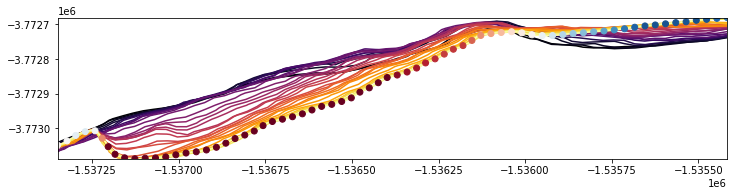

In [3]:
# Set up figure
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Set plot limits to extent of statistics points
bounds = deacl_statistics_gdf.geometry.total_bounds
ax.set_xlim(bounds[[0, 2]])
ax.set_ylim(bounds[[1, 3]])

# Plot data
deacl_statistics_gdf.plot(ax=ax,
                          column='rate_time',
                          cmap='RdBu',
                          vmin=-2.5,
                          vmax=2.5)
deacl_coastlines_gdf.plot(ax=ax, column='year', cmap='inferno', zorder=0)

## DEA Coastlines analysis tools

The following sections provide useful tools for analysing DEA Coastlines data directly within a Jupyter Notebook without needing to load the data into a GIS.
All outputs from the tools below will be saved to a new folder in this directory called `deacoastlines_outputs`.

### Interactive profile selection
This tool allows you to interactively draw a transect over DEA Coastlines annual shoreline data, and get back a table and graph showing how shoreline positions have changed over time.
To use the tool:

1. Run the cell below; an interactive map will appear 
2. Zoom in and use the `Draw a polyline` tool on the left to draw a transect across a set of coastlines
3. Press `Finish` when you are happy with the line, then click `Done` in the top right
4. A graph will appear below the map showing distances along the transect to each annual coastline (distances will be measured from the start of the transect line you drew above)
5. All outputs from the tool will be saved to a new folder in this directory called `deacoastlines_outputs`

> **Optional:** Set `transect_mode='width'` and re-run the cell below to measure the width between two adjacent sets of coastlines (e.g. across the next of a tombolo or sandbar)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Loading DEA Coastlines data...

Exporting transect data to:
    deacoastlines_outputs/deacoastlines_transect_131.873_-12.218.csv

Exporting transect vector to:
    deacoastlines_outputs/deacoastlines_transect_131.873_-12.218.shp
    deacoastlines_outputs/deacoastlines_transect_131.873_-12.218.geojson

Exporting transect figure to:
    deacoastlines_outputs/deacoastlines_transect_131.873_-12.218.png



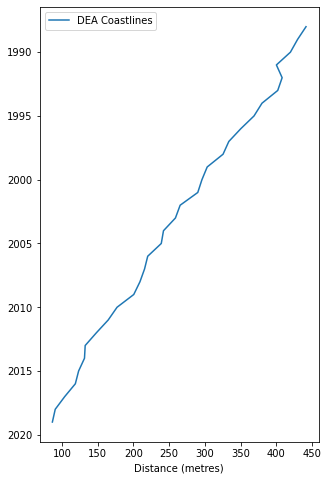

In [4]:
df = deacl_transect(transect_mode='distance',
                    export_csv=True,
                    export_transect=True,
                    export_figure=True)


### Statistics point histogram analysis
This tool allows you to draw a polygon or rectangle around DEA Coastlines rates of change statistics points, and get back a histogram showing the distribution of growing or retreating points.
To use the tool:

1. Run the cell below; an interactive map will appear 
2. Use the `Draw a polygon` or `Draw a rectangle` tools on the left to select a region.
3. Press `Done` in the top right when ready
4. A histogram plot will appear below the map
5. All outputs from the tool will be saved to a new folder in this directory called `deacoastlines_outputs`

> **Optional:** Set `hist_log=True` and re-run the cell below to generate a log-scale histogram plot
   
> **Optional:** Instead of using the interactive map, supply a path to a vector file using the `extent_path` parameter (e.g. `extent_path='study_area.shp`). 
If this option is selected, you can also supply a column name in the dataset to `extent_id_col` which will be used to name the output files (e.g. `extent_id_col='compartment_id'`).
To revert to the interactive map, set `extent_path=None`.



Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Loading DEA Coastlines data...
    Plotting data with log axis after setting non-significant points to 0 m / year

Exporting histogram polygon to:
    deacoastlines_outputs/deacoastlines_polygon_131.733_-12.187.shp
    deacoastlines_outputs/deacoastlines_polygon_131.733_-12.187.geojson

Exporting histogram figure to:
    deacoastlines_outputs/deacoastlines_polygon_131.733_-12.187.png

Exporting raw data to:
    deacoastlines_outputs/deacoastlines_polygon_131.733_-12.187.csv

Exporting summary data to:
    deacoastlines_outputs/deacoastlines_polygon_summary.csv



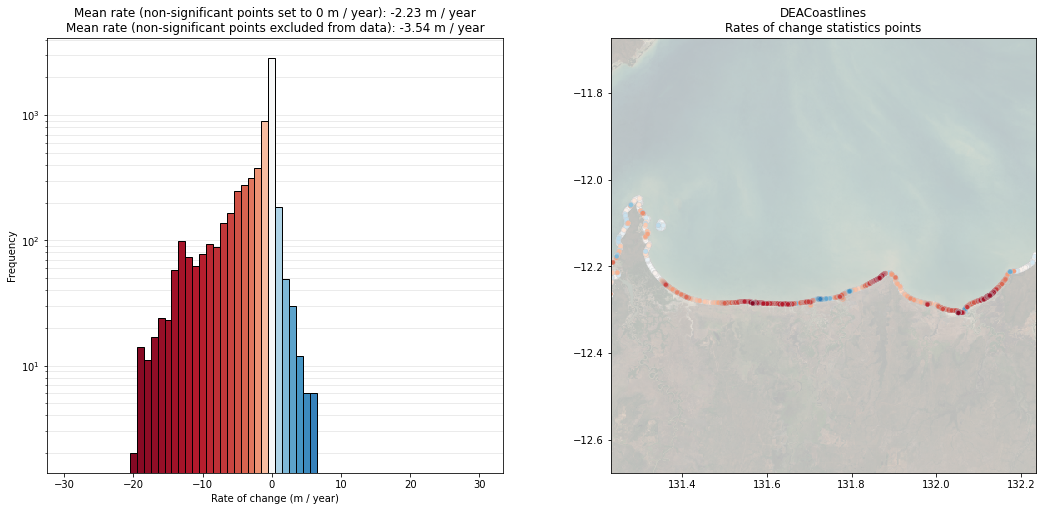

In [5]:
df = rates_hist(extent_path=None,
                extent_id_col=None,
                hist_log=True,
                export_raw_data=True,
                export_summary_data=True,
                export_polygon=True,
                export_figure=True)

### Remove output files
Run this cell to clean up your directory by removing any output files generated by this notebook and saved to the `deacoastlines_outputs` folder. 

> **Note:** This cannot be undone, so ensure any important outputs have been downloaded to your computor before proceeding.


In [6]:
!rm -r deacoastlines_outputs

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Product description and metadata:** For the most up-to-date information about this product, visit the official [Geoscience Australia DEA Coastlines product description](https://cmi.ga.gov.au/data-products/dea/581/dea-coastlines-landsat)

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, email dea@ga.gov.au or sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** September 2020